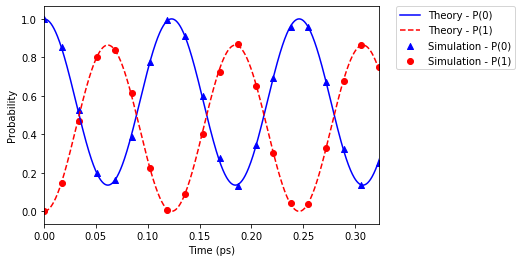

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import math
import cmath
from math import pi
# Qiskit modules
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, Aer, IBMQ
from qiskit import execute
from qiskit import IBMQ
from qiskit import transpile
import qiskit.tools.visualization
from qiskit.tools.visualization import circuit_drawer, plot_histogram
from qiskit.quantum_info import state_fidelity




# The following function generates the results for a time t and plots it in a graphic
def graphic(exc,out,cr,E1,E2,J,step_size,angle_u,iterations,site_1,site_2,init):
    # Required variable declarations
    x=[]
    y1=[]
    y2=[]
    p1=0
    p2=0
    c=0.0299792 #speed of light in cm/ps
    
    # Constants to use when plotting theoretical results
    w=-site_1+site_2
    Gamma=math.sqrt(math.pow(w,2)+4*math.pow(J,2))
    Lambda1=(w+Gamma)/2
    Lambda2=(w-Gamma)/2
    
    job=[] 
    
    for cycles in range(0,iterations): 
        qc = QuantumCircuit(exc,out,cr) # each simulation for a time t, needs a new quantum circuit
        one_qubit_fret(qc,exc,out,cr,E1,E2,step_size,cycles,angle_u,init)
        #backend=provider0.get_backend('ibmq_london')        # <- simulate in a real quantum computer 
        #qc = transpile(qc, backend, optimization_level=3)   # <- using optimizations for that quantum computer
        backend=Aer.get_backend('qasm_simulator')            # <- Or use the QASM simulator
        job_sim = execute(qc, backend, shots=2048)
        job.append(job_sim.job_id())
        result_sim = job_sim.result()
        result_counts = result_sim.get_counts(qc)
        
        # Get the probability of measuring each state (population term):
        if '0' in result_counts:        
            p1+=result_counts['0']/2048
        else:
            p1=0
        if '1' in result_counts:
            p2+=result_counts['1']/2048
        else:
            p2=0
        x.append(step_size*cycles)
        y1.append(p1)
        y2.append(p2)
        p1=0
        p2=0
        
    # Create the theoretical evolution equations
    def func0(x):
        return(math.pow(abs(Lambda1*cmath.exp(-1j*Lambda1*i)/Gamma-Lambda2*cmath.exp(-1j*Lambda2*i)/Gamma),2) for i in x)
    def func1(x):
        return(math.pow(abs(J*(cmath.exp(1j*Lambda1*i)-cmath.exp(1j*Lambda2*i))/Gamma),2) for i in x)
        
    # Plot the theoretical and simulation results
    la = plt.scatter(x,y1,c='b',marker="^",label='Simulation - P(0)')
    lb = plt.scatter(x,y2,c='r',label='Simulation - P(1)')
    t=np.linspace(0,step_size*iterations,num=1000)
    y_t_1=list(func0(t))
    plt.plot(t, y_t_1, 'b',label="Theory - P(0)")
    y_t_2=list(func1(t))
    plt.plot(t,y_t_2 , 'r--',label="Theory - P(1)")
    ll = plt.legend(loc=7)
    lx = plt.xlabel('Time (ps)')
    ly = plt.ylabel('Probability')
    xx = plt.xlim(0,cycles*step_size)
    ll = plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.show()
    return(job)




# Basis transformation matrix
def u(fret,exc,angle_u):
    fret.ry(-2*angle_u,exc[0])

# Application of the diagonal evolution operator
def hamiltonian_evolution(fret,exc,out,step_size,E1,E2):
    ## 0
    fret.barrier()
    fret.x(exc[0])
    fret.crz(-2*E1*step_size,exc[0],out[0])
    fret.x(exc[0])
    ## 1
    fret.barrier()
    fret.crz(-2*E2*step_size,exc[0],out[0])

# Transconjugated basis transformation matrix
def u_transconj(fret,exc,angle_u): 
    fret.ry(2*angle_u,exc[0])

# Initializes an ancilla ("out") at state 1. 
# It also decides what is the initial state, based on the Boolean variable "init".
def state_initialization(fret,exc,out,init):
    fret.x(out[0])
    if (init):
        fret.x(exc[0])
        
        


# The quantum circuit implementation
def one_qubit_fret(fret,exc,out,cr,E1,E2,step_size,cycles,angle_u,init):
    state_initialization(fret,exc,out,init)
    fret.barrier()
    u(fret,exc,angle_u)
    hamiltonian_evolution(fret,exc,out,cycles*step_size,E1,E2)
    fret.barrier()
    u_transconj(fret,exc,angle_u)
    fret.barrier()
    fret.measure(exc,cr)
    
    
    
# SIMULATION

exc = QuantumRegister(1) # 2 molecules
out = QuantumRegister(1) # the ancilla qubit to be initialized at 1.
cr = ClassicalRegister(1) # 1 classical bit to measure "exc".
fret = QuantumCircuit(exc,out,cr)
c=0.0299792 #spped of light in units cm/ps

# NON-RESONANT PARAMETERS
#J=2*pi*132*c
#E1=81227.5*c
#E2=77108.8*c
#angle_u=2.934
#site_1=2*pi*12900*c
#site_2=2*pi*12300*c

# NEAR-RESONANT PARAMETERS
E1=82219*c          # energy eigenvalue 1 in rad.THz
E2=80515.5*c        # energy eigenvalue 2 in rad.THz 
angle_u=2.545       # angle to be used in the basis transformation matrix
site_1=2*pi*13000*c # site energy of the donor molecule, in rad.THz
site_2=2*pi*12900*c # site energy of the acceptor molecule, in rad.THz
J=2*pi*126*c        # coupling strength between the molecules, in rad.THz


step_size=0.017 # defines the increment of time (interval of time between points in the plot)
iterations=20 # defines the number of times the system will be simulated (the number of points in the plot)



#provider0 = IBMQ.load_account() # <- load IBM account if the circuit will be run in a real quantum computer

# TOO SEE THE OUTPUT CIRCUIT: (put in comment the call "jobs=graphic(....)" and uncomment the following:)
#one_qubit_fret(fret,exc,out,cr,E1,E2,step_size,iterations,angle_u,False)
#fret.draw(output='mpl')

jobs=graphic(exc,out,cr,E1,E2,J,step_size,angle_u,iterations,site_1,site_2,False)




# Too see the optimized quantum circuit in the chosen quantum computer:


exc = QuantumRegister(1) # 2 molecules
out = QuantumRegister(1) # the ancilla qubit to be initialized at 1.
cr = ClassicalRegister(1) # 1 classical bit to measure "exc".
fret = QuantumCircuit(exc,out,cr)
c=0.0299792 #spped of light in units cm/ps

# NON-RESONANT PARAMETERS
#E1=81227.5*c
#E2=77108.8*c
#angle_u=2.934

# NEAR-RESONANT PARAMETERS
E1=82219*c          # energy eigenvalue 1 in rad.THz
E2=80515.5*c        # energy eigenvalue 2 in rad.THz 
angle_u=2.545       # angle to be used in the basis transformation matrix


step_size=0.017 # defines the increment of time (interval of time between points in the plot)
iterations=1 # defines the number of times the system will be simulated (the number of points in the plot)

#UNCOMMENT TO SEE THE OPTIMIZED CIRCUIT:

#provider0 = IBMQ.load_account()
#backend=provider0.get_backend('ibmq_london')
#one_qubit_fret(fret,exc,out,cr,E1,E2,step_size,iterations,angle_u,False)
#qc = transpile(fret, backend, optimization_level=3)
#qc.draw(output='mpl')